# Bài tập nhóm lần 2 (Bản nộp lại)

Thành viên:
- 23C24004 - Lê Nhựt Nam
- 23C24005 - Phạm Thừa Tiểu Thành

Phân công công việc
- Thành -> xử lý đa cộng tuyến, mô hình mpg, boston
- Nam -> trực quan, trình bày, lựa chọn mô hình tốt nhất mpg, boston

## Import các thứ

In [1]:
library(dplyr)
library(tidyr)
library(car)
library(MASS)
library(leaps)
library(Metrics)
library(lmtest)
library(ggplot2)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: carData


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric




## Hàm phụ trợ

In [2]:
remove_high_vif <- function(regr_variable, data, threshold = 5) {  
    library(car)
    library(dplyr)
    
    stop <- FALSE
    while(stop == FALSE) {
        # Tính VIF cho các biến độc lập
        model <- lm(as.formula(paste(regr_variable, "~ .")), data = data)
        vif_values <- vif(model)
        # Tìm các biến có VIF cao hơn ngưỡng
        high_vif <- which(vif_values > threshold)
        
        if (length(high_vif) > 0) {
            # Loại bỏ các biến có VIF cao
            remove_index <- which.max(high_vif)
            rm_names <- names(data[, !names(data) %in% regr_variable])
            rm_name <- rm_names[remove_index]
            data <- data[, !names(data) %in% rm_name]
        } else {
            stop <- TRUE
        }
    }
    return(data)
}

## Đọc dữ liệu

In [3]:
# Đọc dữ liệu từ tập tin
raw_data <- read.table('data/auto-mpg.data', header = FALSE, sep = '', stringsAsFactors = FALSE)
names(raw_data) <- c("mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model_year", "origin", "carname")

## Khám phá và tiền xử lý dữ liệu

### Dữ liệu có bao nhiều dòng và bao nhiêu cột?

In [4]:
# Kích thước của dữ liệu
# Ta thấy dữ liệu có 398 dòng và 9 cột
dim(raw_data)

[1] 398   9

### Mỗi dòng có ý nghĩa gì? Liệu có tồn tại dòng nào mà mang ý nghĩa khác với các dòng còn lại không?

Dựa trên thông tin của tập dữ liệu, ta thấy mỗi dòng mang ý nghĩa khác nhau, tức là mỗi quan trắc độc lập nhau.

### Dữ liệu có bị trùng lặp không?

In [5]:
# Kiểm tra dữ liệu trùng lặp
duplicates <- raw_data[duplicated(raw_data), ]
duplicate_counts <- table(raw_data[duplicated(raw_data), ])
duplicates # Không có dữ liệu trùng lặp

mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,carname
<dbl>,<int>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<chr>


### Mỗi cột mang ý nghĩa gì?

In [6]:
# Đầu tiên, ta xem xét một số quan trắc
str(raw_data)

'data.frame':	398 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : chr  "130.0" "165.0" "150.0" "150.0" ...
 $ weight      : num  3504 3693 3436 3433 3449 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ model_year  : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ carname     : chr  "chevrolet chevelle malibu" "buick skylark 320" "plymouth satellite" "amc rebel sst" ...


Thông tin các biến dữ liệu:
1. mpg (liên tục - continuous): số mét mỗi galon nhiên liệu.
2. cylinders (rời rạc đa giá trị - multi-valued discrete): số lượng engine cylinders.
3. displacement (liên tục - continuous): 
4. horsepower (liên tục - continuous): công suất được tạo ra bởi động cơ nhằm di chuyển chiếc xe.
5. weight (liên tục - continuous): trọng lượng xe
6. acceleration (liên tục - continuous): gia tốc của một động cơ có thể đạt được mỗi giây
7. model year (rời rạc đa giá trị - multi-valued discrete): năm mà xe ra đời từ năm 1970 đến năm 1982.
8. origin (rời rạc đa giá trị - multi-valued discrete): xuất xứ của chiếc xe, nếu là 1 thì đến từ USA, nếu là 2 thì đến từ Europe, và 3 là từ ASia.
9. car name (string (unique for each instance)): tên chiếc xe, giá trị này là duy nhất cho mỗi chiếc xe.

### Có cột nào có kiểu dữ liệu chưa phù hợp? Nếu có, cần chuyển đổi sang kiểu phù hợp

Ta để ý, `horsepower` đang mang kiểu char, vì thế là cần chuyển sang kiểu số thực.

In [7]:
raw_data$horsepower <- as.integer(raw_data$horsepower)
# raw_data$origin <- as.character(raw_data$origin)
# raw_data$model_year <- as.character(raw_data$model_year)
# raw_data$cylinders <- as.character(raw_data$cylinders)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


In [8]:
str(raw_data)

'data.frame':	398 obs. of  9 variables:
 $ mpg         : num  18 15 18 16 17 15 14 14 14 15 ...
 $ cylinders   : int  8 8 8 8 8 8 8 8 8 8 ...
 $ displacement: num  307 350 318 304 302 429 454 440 455 390 ...
 $ horsepower  : int  130 165 150 150 140 198 220 215 225 190 ...
 $ weight      : num  3504 3693 3436 3433 3449 ...
 $ acceleration: num  12 11.5 11 12 10.5 10 9 8.5 10 8.5 ...
 $ model_year  : int  70 70 70 70 70 70 70 70 70 70 ...
 $ origin      : int  1 1 1 1 1 1 1 1 1 1 ...
 $ carname     : chr  "chevrolet chevelle malibu" "buick skylark 320" "plymouth satellite" "amc rebel sst" ...


### Các cột với kiểu dữ liệu số phân bố như thế nào? 

In [9]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

In [10]:
# Function to calculate median
median_custom <- function(df) {
  round(quantile(df, 0.5, na.rm = TRUE), 1)
}

In [11]:
# Function to calculate lower quartile
lower_quartile <- function(df) {
  round(quantile(df, 0.25, na.rm = TRUE), 1)
}

In [12]:
# Function to calculate upper quartile
upper_quartile <- function(df) {
  round(quantile(df, 0.75, na.rm = TRUE), 1)
}

In [13]:
# Select numerical columns
num_col_info_df <- as.data.frame(raw_data)  %>%
  select_if(is.numeric)

# Aggregating statistics
num_col_info_df <- num_col_info_df %>%
  reframe(
    missing_ratio = sapply(., missing_ratio),
    min = sapply(., min, na.rm = TRUE),
    lower_quartile = sapply(., lower_quartile),
    median = sapply(., median_custom),
    upper_quartile = sapply(., upper_quartile),
    max = sapply(., max, na.rm = TRUE)
  )

  print(num_col_info_df)

  missing_ratio  min lower_quartile median upper_quartile    max
1           0.0    9           17.5   23.0           29.0   46.6
2           0.0    3            4.0    4.0            8.0    8.0
3           0.0   68          104.2  148.5          262.0  455.0
4           1.5   46           75.0   93.5          126.0  230.0
5           0.0 1613         2223.8 2803.5         3608.0 5140.0
6           0.0    8           13.8   15.5           17.2   24.8
7           0.0   70           73.0   76.0           79.0   82.0
8           0.0    1            1.0    1.0            2.0    3.0


Như ta thấy, có missing values ở cột thứ 3 (horsepower), với tỷ lệ 1.5%. Vì thế ta sẽ loại bỏ các dòng chứa missing value.

In [14]:
df <- as.data.frame(raw_data) %>%
  drop_na()

Kiểm tra lại

In [15]:
# Select numerical columns
num_col_info_df <- df  %>%
  select_if(is.numeric)

# Aggregating statistics
num_col_info_df <- num_col_info_df %>%
  reframe(
    missing_ratio = sapply(., missing_ratio),
    min = sapply(., min, na.rm = TRUE),
    lower_quartile = sapply(., lower_quartile),
    median = sapply(., median_custom),
    upper_quartile = sapply(., upper_quartile),
    max = sapply(., max, na.rm = TRUE)
  )

  print(num_col_info_df)

  missing_ratio  min lower_quartile median upper_quartile    max
1             0    9           17.0   22.8           29.0   46.6
2             0    3            4.0    4.0            8.0    8.0
3             0   68          105.0  151.0          275.8  455.0
4             0   46           75.0   93.5          126.0  230.0
5             0 1613         2225.2 2803.5         3614.8 5140.0
6             0    8           13.8   15.5           17.0   24.8
7             0   70           73.0   76.0           79.0   82.0
8             0    1            1.0    1.0            2.0    3.0


Như vậy, ta đã loại bỏ xong các dòng chứa missing values. Và chúng ta còn lại:

In [16]:
dim(df) # Loại bỏ 6 dòng dữ liệu, 398 - 6 = 392

[1] 392   9

In [17]:
# Một số thống kê mô tả cho bộ dữ liệu
print(summary(df))

      mpg          cylinders      displacement     horsepower        weight    
 Min.   : 9.00   Min.   :3.000   Min.   : 68.0   Min.   : 46.0   Min.   :1613  
 1st Qu.:17.00   1st Qu.:4.000   1st Qu.:105.0   1st Qu.: 75.0   1st Qu.:2225  
 Median :22.75   Median :4.000   Median :151.0   Median : 93.5   Median :2804  
 Mean   :23.45   Mean   :5.472   Mean   :194.4   Mean   :104.5   Mean   :2978  
 3rd Qu.:29.00   3rd Qu.:8.000   3rd Qu.:275.8   3rd Qu.:126.0   3rd Qu.:3615  
 Max.   :46.60   Max.   :8.000   Max.   :455.0   Max.   :230.0   Max.   :5140  
  acceleration     model_year        origin        carname         
 Min.   : 8.00   Min.   :70.00   Min.   :1.000   Length:392        
 1st Qu.:13.78   1st Qu.:73.00   1st Qu.:1.000   Class :character  
 Median :15.50   Median :76.00   Median :1.000   Mode  :character  
 Mean   :15.54   Mean   :75.98   Mean   :1.577                     
 3rd Qu.:17.02   3rd Qu.:79.00   3rd Qu.:2.000                     
 Max.   :24.80   Max.   :82.00  

### Các cột với kiểu dữ liệu phân loại phân bố như thế nào?

In [18]:
# Function to calculate missing ratio
missing_ratio <- function(s) {
  round(mean(is.na(s)) * 100, 1)
}

In [19]:
# Function to calculate number of unique values
num_values <- function(s) {
  s <- strsplit(s, ";")
  s <- unlist(s)
  length(unique(s))
}

In [20]:
# Function to calculate value ratios
value_ratios <- function(s) {
  s <- strsplit(s, ";")
  s <- unlist(s)
  totalCount <- sum(!is.na(s))
  value_counts <- table(s)
  ratios <- round((value_counts / totalCount) * 100, 1)
  as.list(ratios)
}

In [21]:
# Select categorical columns (assuming character columns as categorical)
cat_col_info_df <-  df  %>%
  select_if(is.character)

# Function to aggregate results for each column
aggregate_results <- function(df) {
  result <- data.frame(
    column = names(df),
    missing_ratio = sapply(df, missing_ratio),
    num_values = sapply(df, num_values),
    value_ratios = I(lapply(df, value_ratios))
  )
  result
}

# Apply the aggregation function
cat_col_info_df <- aggregate_results(cat_col_info_df)

# Print the result
print(cat_col_info_df)

         column missing_ratio num_values value_ratios
carname carname             0        301 0.3, 0.3....


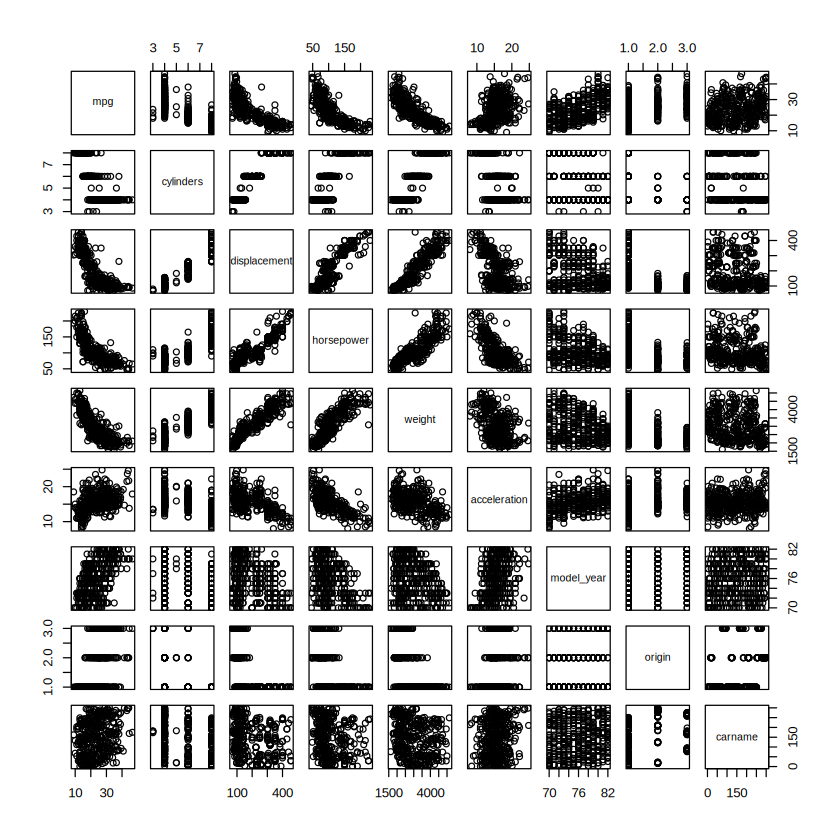

In [22]:
# Trực quan dữ liệu
plot(df)

In [23]:
round(cor(df[, !(names(df) %in% c("cylinders", "model_year", "origin", "carname"))]), 2)

,mpg,displacement,horsepower,weight,acceleration
mpg,1.00,-0.81,-0.78,-0.83,0.42
displacement,-0.81,1.00,0.90,0.93,-0.54
horsepower,-0.78,0.90,1.00,0.86,-0.69
weight,-0.83,0.93,0.86,1.00,-0.42
acceleration,0.42,-0.54,-0.69,-0.42,1.00


In [24]:
# factor biến origin sang biến giả
# df$cylinders = as.factor(df$cylinders)
# df$model_year = as.factor(df$model_year)
df$origin = as.factor(df$origin)

### Khảo sát ngoại lai

In [25]:
# Function to identify and remove outliers using Cook's distance
identify_and_remove_outliers_cooks <- function(df, model) {
  # Check if the dataframe and model are provided
  if (!is.data.frame(df)) {
    stop("Input 'df' must be a dataframe")
  }
  if (!inherits(model, "lm")) {
    stop("Input 'model' must be a linear regression model (lm)")
  }
  
  # Obtain Cook's distance
  cooks_dist <- cooks.distance(model)
  
  # Find outliers based on a threshold
  outlier_threshold <- 4 / nrow(df) # Adjust the threshold as needed
  outliers <- which(cooks_dist > outlier_threshold)
  
  # Remove outliers from the dataframe
  df_cleaned <- df[-outliers, ]
  
  # Print Cook's distance and identified outliers
  cat("Cook's distance:\n")
  print(cooks_dist)
  cat("\nIdentified outliers:\n")
  print(outliers)
  
  return(df_cleaned)
}

model <- lm(mpg ~ ., data = df)
df<- identify_and_remove_outliers_cooks(df, model)

Cook's distance:
           1            2            3            4            5            6 
5.672940e-03          NaN          NaN          NaN          NaN 2.427130e-03 
           7            8            9           10           11           12 
2.292226e-03 8.565969e-04 1.393825e-03          NaN          NaN          NaN 
          13           14           15           16           17           18 
         NaN 7.241435e-03          NaN 6.225298e-04 2.005960e-05 1.269427e-03 
          19           20           21           22           23           24 
1.283024e-04          NaN 1.880560e-03          NaN          NaN          NaN 
          25           26           27           28           29           30 
1.912746e-03          NaN          NaN          NaN          NaN 1.283024e-04 
          31           32           33           34           35           36 
         NaN 3.086253e-05 2.787132e-04          NaN 5.672940e-03          NaN 
          37           38          

In [26]:
dim(df)

[1] 377   9

Như vậy, ta thấy có các giá trị ngoại lai xuất hiện trong biến horsepower và acceleration. Và ta đã thực hiện loại bỏ các giá trị này dựa trên  Cook's distance.

## Xử lý hiện tượng đa cộng tuyến

Loại bỏ cột  9 (carname) vì tỷ lệ others chiếm đa số, không có ý nghĩa trong thống kê dựa trên phần mô tả dữ liệu, trong đó: 
- carname (ford pinto - 2%, ford maverick - 1%, các giá trị khác - 97%)

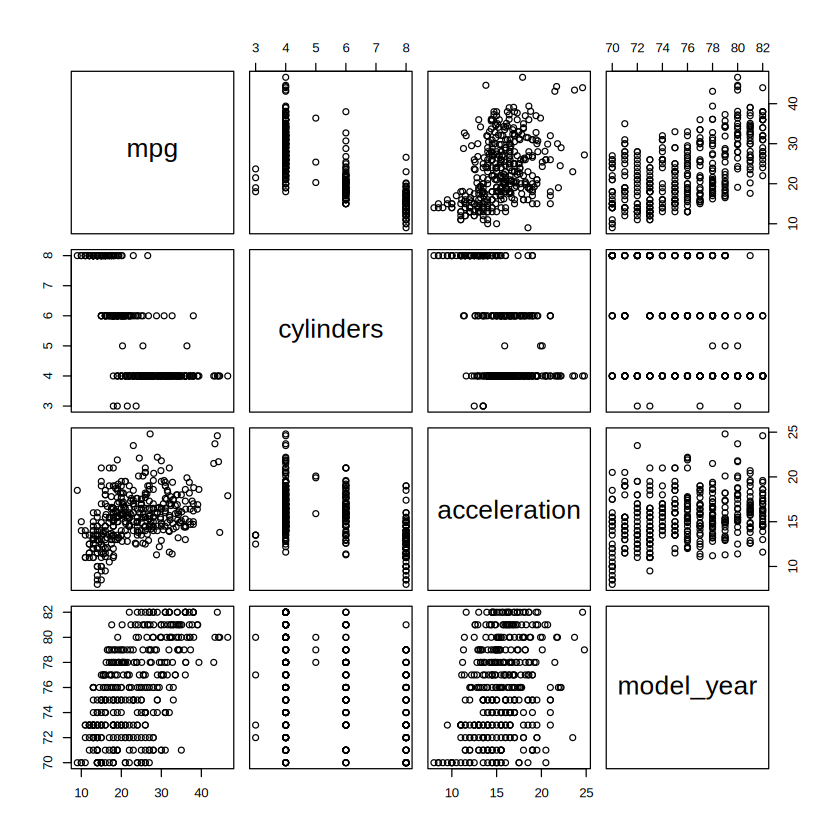

In [27]:
cleaned_df = remove_high_vif("mpg", df[ ,-c(9)], threshold=5)
plot(cleaned_df[,!(names(cleaned_df) %in% c("origin"))])

In [28]:
round(cor(cleaned_df[, !(names(cleaned_df) %in% c("origin"))]), 2)

,mpg,cylinders,acceleration,model_year
mpg,1.00,-0.78,0.42,0.59
cylinders,-0.78,1.00,-0.52,-0.36
acceleration,0.42,-0.52,1.00,0.29
model_year,0.59,-0.36,0.29,1.00


## Phân chia tập train/ test

In [29]:
n = nrow(cleaned_df) # 398
train_indices <- sample(seq_len(n), size = 0.7 * n)
train = cleaned_df[train_indices,]
test = cleaned_df[-train_indices,]

In [30]:
# số chiều tập train
dim(train)

[1] 263   5

In [31]:
# số chiều tập test
dim(test)

[1] 114   5

In [32]:
# xem một số quan trắc của tập train
str(train)

'data.frame':	263 obs. of  5 variables:
 $ mpg         : num  22 13 23 31 31 29.8 32 22.5 20.2 27.2 ...
 $ cylinders   : int  6 8 4 4 4 4 4 6 6 4 ...
 $ acceleration: num  14.5 13 15 16 19 15.5 17 17.6 17.1 14.7 ...
 $ model_year  : int  76 73 75 74 71 80 76 76 81 78 ...
 $ origin      : Factor w/ 3 levels "1","2","3": 1 1 2 2 3 3 3 1 1 3 ...


## Khớp mô hình và lựa chọn model tốt nhất với step

### Khớp mô hình

In [33]:
model = lm(mpg~., data=train)
model_best <- step(model, direction = "both",trace = FALSE)

In [34]:
# Tóm tắt mô hình
print(summary(model_best))


Call:
lm(formula = mpg ~ cylinders + model_year + origin, data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.0641  -2.1503  -0.3473   2.0367  14.2376 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -16.24129    5.98967  -2.712 0.007147 ** 
cylinders    -2.47749    0.19239 -12.877  < 2e-16 ***
model_year    0.68226    0.07324   9.315  < 2e-16 ***
origin2       2.79864    0.78071   3.585 0.000403 ***
origin3       3.93287    0.74197   5.301 2.48e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.019 on 258 degrees of freedom
Multiple R-squared:  0.7338,	Adjusted R-squared:  0.7297 
F-statistic: 177.8 on 4 and 258 DF,  p-value: < 2.2e-16



In [35]:
print(model_best$coefficients)

(Intercept)   cylinders  model_year     origin2     origin3 
-16.2412866  -2.4774884   0.6822599   2.7986423   3.9328697 


### Phân tích kết quả

Từ kết quả này ta có công thức ước lượng hồi quy như sau:

mpg = -27.654537 - 2.269719 * cylinders + 0.820366 * model_year + 3.021139 * origin2 + 4.713792 * origin3

Và dễ dàng thấy được, biến origin có một tác động lớn đến kết quả dự đoán

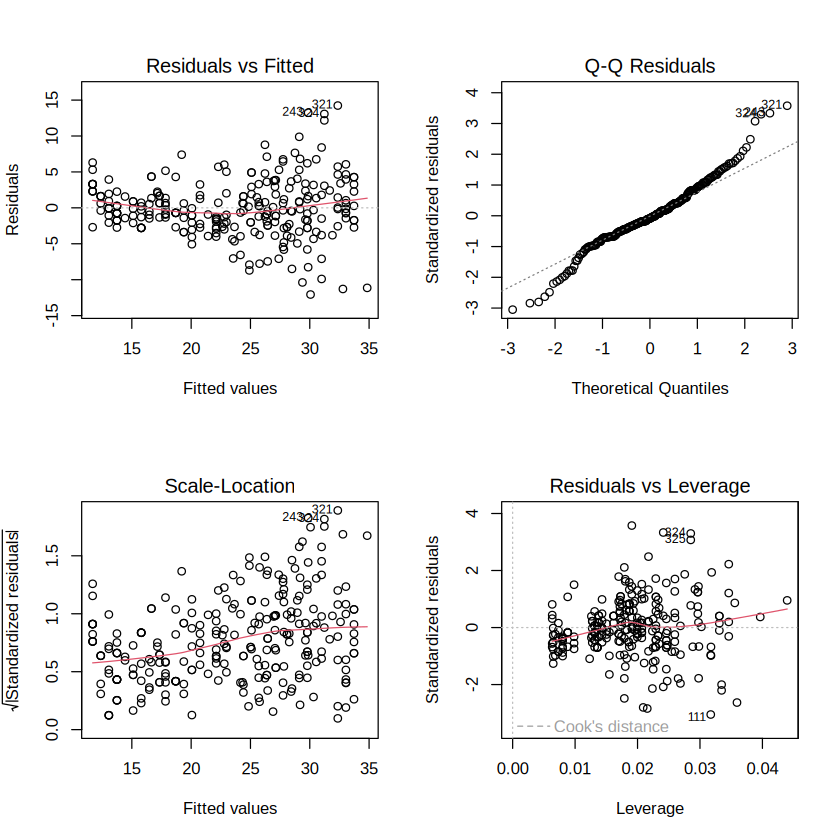

In [36]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(model_best)

#### Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

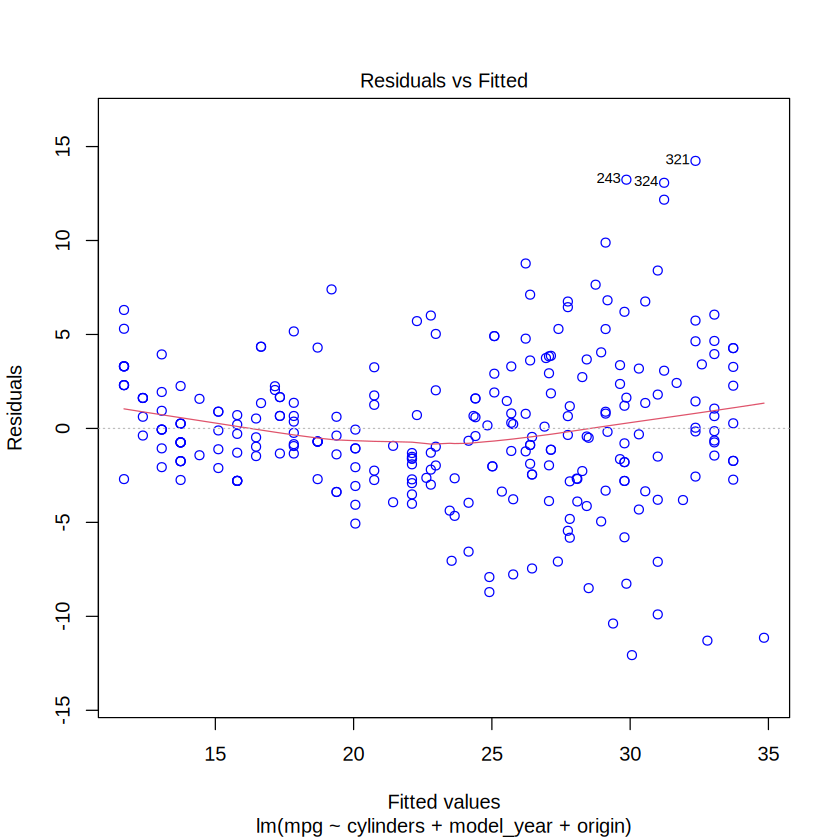

In [37]:
plot(model_best, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương đối đồng đều. Điều này chứng tỏ không có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Normal Q–Q (quantile-quantile) Plot

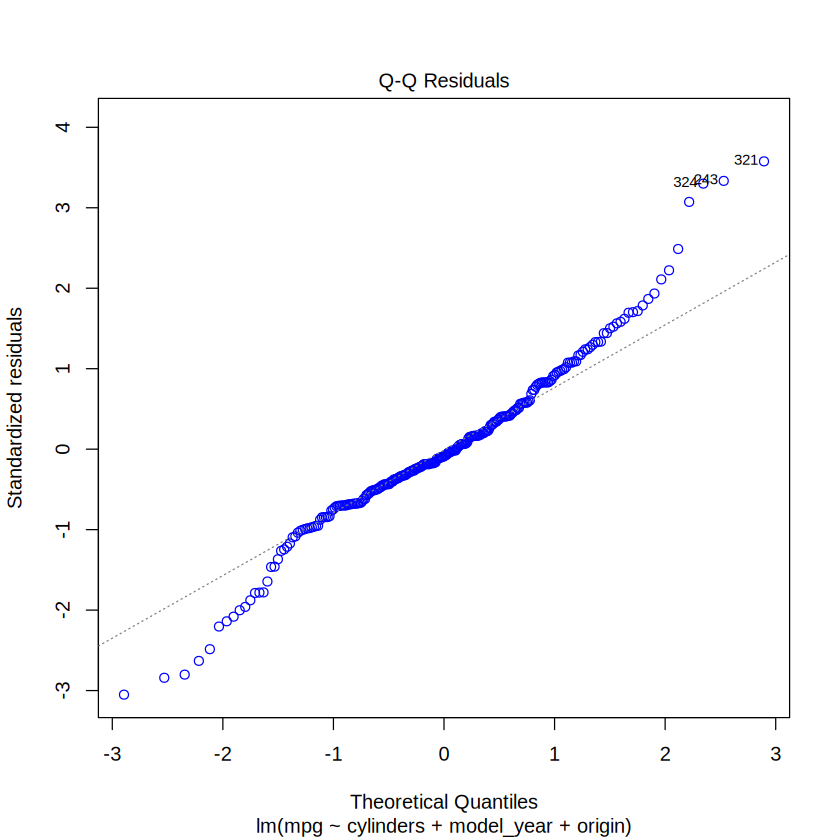

In [38]:
plot(model_best, which=2, col=c("blue")) # QQ Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có thể xem phân phối chuẩn.

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [39]:
shapiro.test(residuals(model_best))


	Shapiro-Wilk normality test

data:  residuals(model_best)
W = 0.97205, p-value = 5.011e-05


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Scale-Location

Biểu đồ scale-location kiểm định giả định hồi quy về phương sai bằng nhau (homoscedasticity), tức là giá trị thặng dư có phương sai bằng với đường hồi quy.

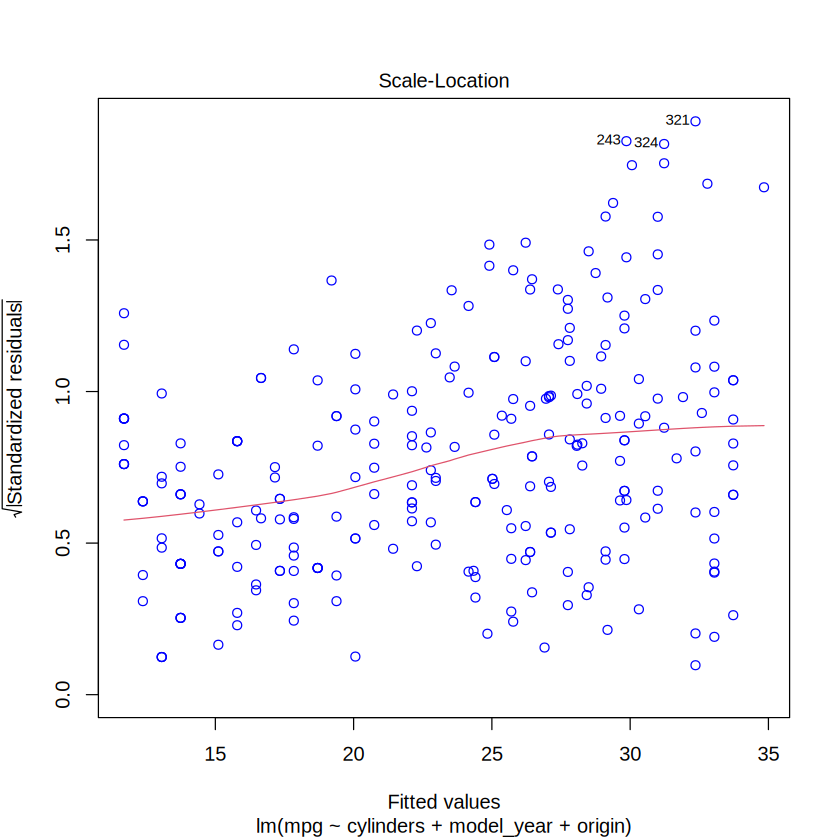

In [40]:
plot(model_best, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần như nằm ngang trên biểu đồ. Nếu đúng như vậy thì giả định về tính đồng nhất được thỏa mãn đối với mô hình hồi quy đã cho. Nghĩa là, độ phân tán của giá trị thặng dư gần như bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng  dư phải được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên gần như bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [41]:
# Breusch-Pagan Test
bptest(model_best)


	studentized Breusch-Pagan test

data:  model_best
BP = 33.311, df = 4, p-value = 1.032e-06


Như vậy, ta thấy p-value bé hơn múc ý nghĩa 0.05 rất nhiều, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là homoscedastic

#### Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

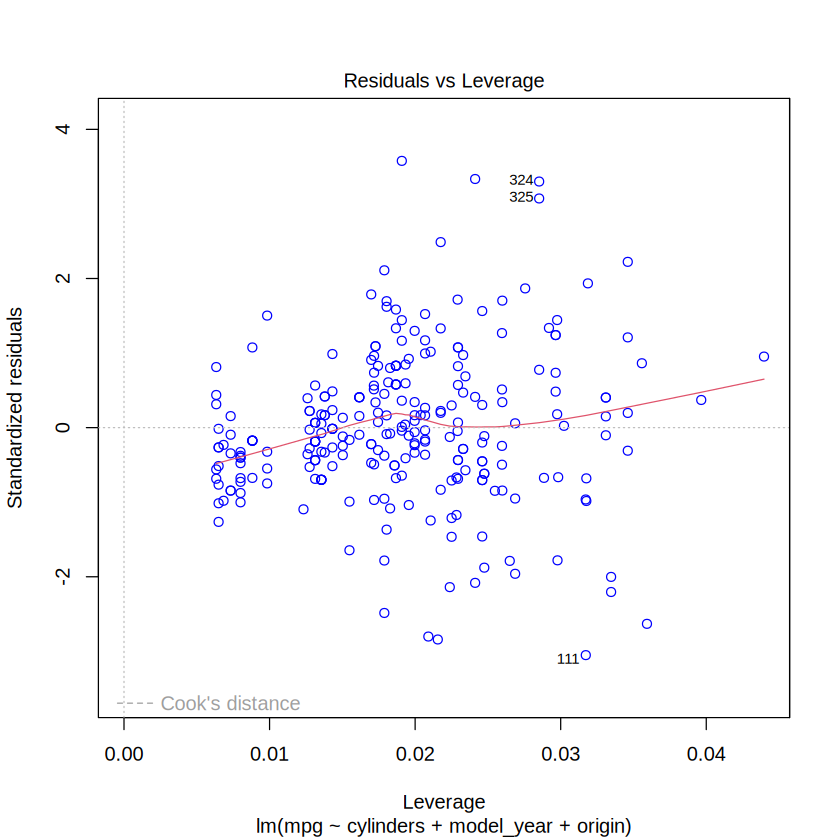

In [42]:
plot(model_best, which=5, col=c("blue"))  # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

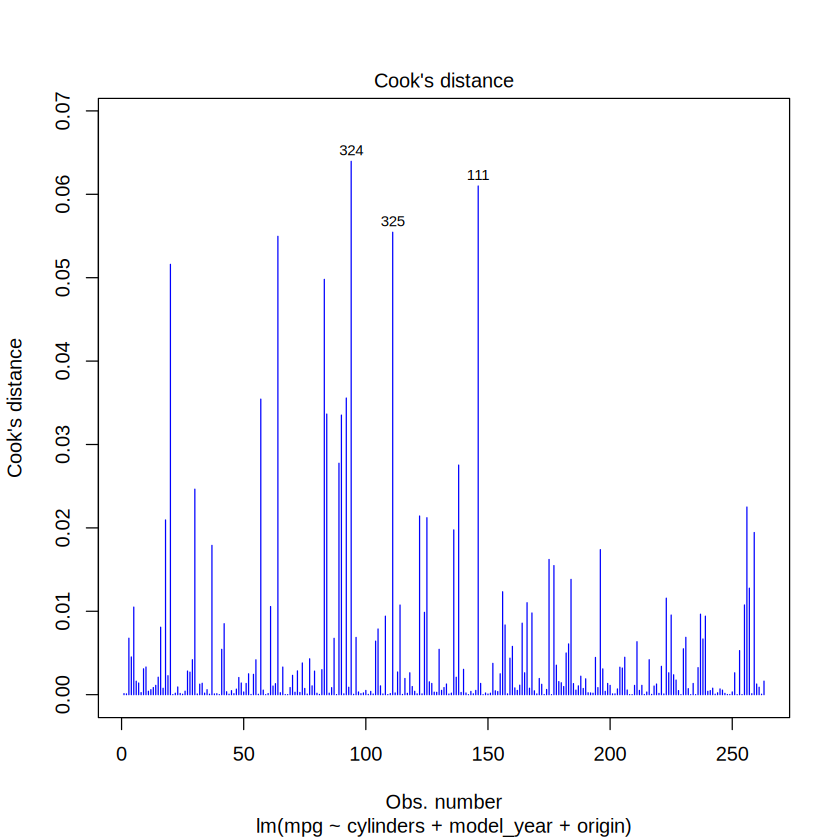

In [43]:
plot(model_best, which=4, col=c("blue"))  # Cook's Distance

### Dự đoán và đánh giá kết quả

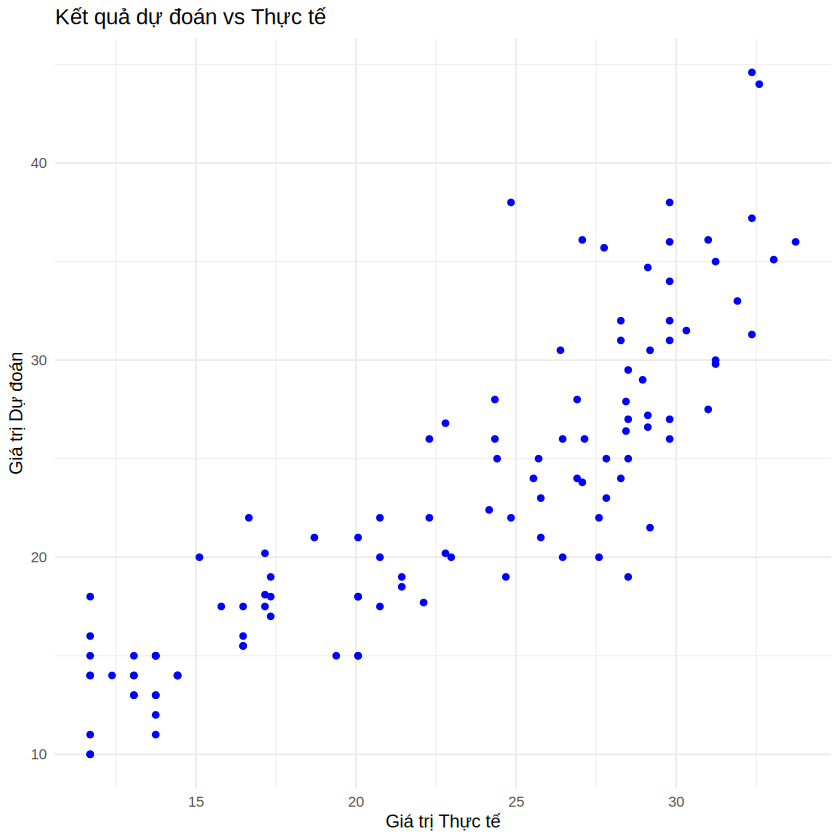

In [44]:
# predict
results <- predict(model_best, test)
df <- data.frame(
    du_doan <- results,
    label <- test$mpg
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

In [45]:
rmse(results, test$mpg)

[1] 3.916123

## Khớp mô hình và lựa chọn model tốt nhất với leaps

Tìm kiếm mô hình tốt nhất bằng regsubsets mà leaps cung cấp

In [46]:
models <- regsubsets(mpg~., data = train, nvmax = 5, method = "seqrep")

In [47]:
print(summary(models))

Subset selection object
Call: regsubsets.formula(mpg ~ ., data = train, nvmax = 5, method = "seqrep")
5 Variables  (and intercept)
             Forced in Forced out
cylinders        FALSE      FALSE
acceleration     FALSE      FALSE
model_year       FALSE      FALSE
origin2          FALSE      FALSE
origin3          FALSE      FALSE
1 subsets of each size up to 5
Selection Algorithm: 'sequential replacement'
         cylinders acceleration model_year origin2 origin3
1  ( 1 ) "*"       " "          " "        " "     " "    
2  ( 1 ) "*"       " "          "*"        " "     " "    
3  ( 1 ) "*"       " "          "*"        " "     "*"    
4  ( 1 ) "*"       " "          "*"        "*"     "*"    
5  ( 1 ) "*"       "*"          "*"        "*"     "*"    


Các dấu sao (*) ở cuối kết quả đầu ra cho biết biến dự đoán nào thuộc mô hình hồi quy tốt nhất cho từng mô hình có thể có với số lượng biến dự đoán khác nhau.

- Đối với mô hình chỉ có một biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng cylinders làm biến dự đoán.

- Đối với mô hình có hai biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng cylinders và model_year làm biến dự đoán.

- Đối với mô hình có ba biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng cylinders, model_year và origin2 làm biến dự đoán.

- Đối với mô hình có bốn biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng cylinders, model_year, origin2 và origin3 làm biến dự đoán.

- Đối với mô hình có năm biến dự đoán, mô hình hồi quy tốt nhất được tạo ra bằng cách sử dụng cylinders, model_year, origin2, origin3 và acceleration làm biến dự đoán.

In [48]:
models_summary <- summary(models)
models_summary$which

,(Intercept),cylinders,acceleration,model_year,origin2,origin3
1,TRUE,TRUE,FALSE,FALSE,FALSE,FALSE
2,TRUE,TRUE,FALSE,TRUE,FALSE,FALSE
3,TRUE,TRUE,FALSE,TRUE,FALSE,TRUE
4,TRUE,TRUE,FALSE,TRUE,TRUE,TRUE
5,TRUE,TRUE,TRUE,TRUE,TRUE,TRUE


Xem xét chỉ số cp

In [49]:
# Chỉ số cp
print(models_summary $cp)

[1] 124.452058  31.973279  16.379738   5.504385   6.000000


- Giá trị CP cho mô hình với cylinders làm biến dự đoán là `115.488398`.
- Giá trị CP cho mô hình với cylinders và model_year làm biến dự đoán là `24.030410`.
- Giá trị CP cho mô hình với cylinders, model_year và origin2 làm các biến dự đoán là `11.421186`.
- Giá trị CP cho mô hình với cylinders, model_year, origin2 và origin3 làm các biến dự đoán là `4.001029`.
- Giá trị CP cho mô hình với cylinders, model_year, origin2, origin3 và acceleration làm các biến dự đoán là `6`.

Xem xét chỉ số R-hiệu chỉnh

In [50]:
print(models_summary$adjr2)

[1] 0.6036262 0.7001399 0.7173090 0.7296773 0.7302047


- Giá trị bình phương R hiệu chỉnh cho mô hình với cylinders làm biến dự đoán là `0.6084890`.
- Giá trị bình phương R hiệu chỉnh cho mô hình với cylinders và model_year làm biến dự đoán là `0.7050652`.
- Giá trị bình phương R hiệu chỉnh cho mô hình với cylinders, model_year và origin2 làm các biến dự đoán là `0.7193177`.
- Giá trị bình phương R hiệu chỉnh cho mô hình với cylinders, model_year, origin2 và origin3 làm các biến dự đoán là `0.7281926`.
- Giá trị bình phương R hiệu chỉnh cho mô hình với cylinders, model_year, origin2, origin3 và acceleration làm các biến dự đoán là `0.7271361`.

In [51]:
# Xem xét chỉ số BIC
print(models_summary $bic)

[1] -233.2410 -302.0664 -313.0146 -320.2260 -316.1888


- Giá trị BIC cho mô hình với cylinders làm biến dự đoán là `-236.4875`.
- Giá trị BIC cho mô hình với cylinders và model_year làm biến dự đoán là `-306.4221`.
- Giá trị BIC cho mô hình với cylinders, model_year và origin2 làm các biến dự đoán là `-314.8901`.
- Giá trị BIC cho mô hình với cylinders, model_year, origin2 và origin3 làm các biến dự đoán là `-318.7855`.
- Giá trị BIC cho mô hình với cylinders, model_year, origin2, origin3 và acceleration làm các biến dự đoán là `-313.2144`.

Bây giờ, ta lựa chọn mô hình tốt nhất có Bayesian Information Criterion (BIC) nhỏ nhất

In [52]:
best_model_index <- which.min(models_summary $bic)
best_model <- models_summary$which[best_model_index, ]
print(best_model)
best_vars <- names(best_model[best_model])
best_vars <- best_vars[best_vars != "(Intercept)"]
print(best_vars)

 (Intercept)    cylinders acceleration   model_year      origin2      origin3 
        TRUE         TRUE        FALSE         TRUE         TRUE         TRUE 
[1] "cylinders"  "model_year" "origin2"    "origin3"   


In [53]:
# Xây dựng mô hình tốt nhất
formula_str <- paste("mpg ~ ", paste(best_vars, collapse = " + "))
formula_str <- "mpg ~ cylinders + model_year + origin"
best_model_lm <- lm(as.formula(formula_str), data=train)

In [54]:
# Xem tóm tắt của mô hình tốt nhất
summary(best_model_lm)


Call:
lm(formula = as.formula(formula_str), data = train)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.0641  -2.1503  -0.3473   2.0367  14.2376 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -16.24129    5.98967  -2.712 0.007147 ** 
cylinders    -2.47749    0.19239 -12.877  < 2e-16 ***
model_year    0.68226    0.07324   9.315  < 2e-16 ***
origin2       2.79864    0.78071   3.585 0.000403 ***
origin3       3.93287    0.74197   5.301 2.48e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.019 on 258 degrees of freedom
Multiple R-squared:  0.7338,	Adjusted R-squared:  0.7297 
F-statistic: 177.8 on 4 and 258 DF,  p-value: < 2.2e-16


In [55]:
print(best_model_lm$coefficients)

(Intercept)   cylinders  model_year     origin2     origin3 
-16.2412866  -2.4774884   0.6822599   2.7986423   3.9328697 


### Phân tích kết quả

Từ kết quả này ta có công thức ước lượng hồi quy như sau:

`mpg = -20.9123317 -2.4836039 * cylinders + 0.7472665 * model_year + 2.4626242 * origin2 + 3.6086680 * origin3`

Và dễ dàng thấy được, biến origin3 có một tác động lớn đến kết quả dự đoán

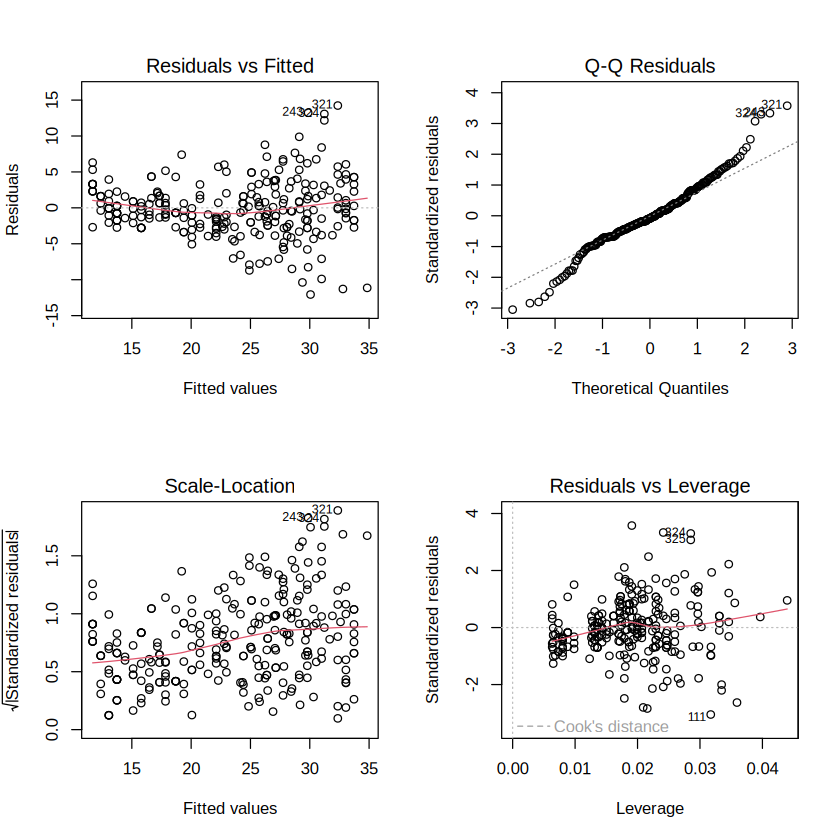

In [56]:
# Trực quan hóa
par(mfrow = c(2, 2))
plot(best_model_lm)

#### Residuals vs Fitted Plot

Biểu đồ **Residuals vs Fitted Plot** đưa ra dấu hiệu nếu có các mẫu phi tuyến tính. Để hồi quy tuyến tính chính xác, dữ liệu cần phải tuyến tính nên điều này sẽ kiểm tra xem điều kiện đó có được đáp ứng hay không.

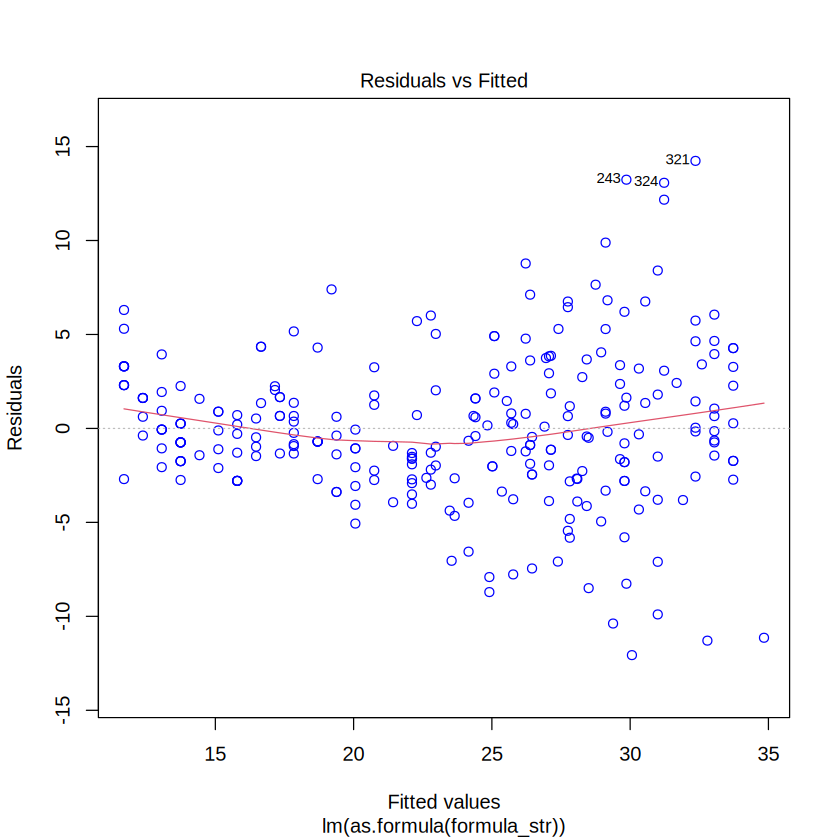

In [57]:
plot(best_model_lm, which=1, col=c("blue")) # Residuals vs Fitted Plot

Dựa trên biểu đồ này, ta thấy đường cong màu đỏ có dáng gần như một đường thẳng, và các phần tử trải dọc theo đường cong này một cách tương đối đồng đều. Điều này chứng tỏ không có quan hệ phi tuyến xuất hiện trong dữ liệu.

#### Normal Q–Q (quantile-quantile) Plot

Các giá trị thặng dư (residual) nên có phân phối chuẩn. Để kiểm tra điều này, chúng ta cần quan sát biểu đồ QQ Residuals plot, nếu các điểm được xếp thành một đường thẳng (hoặc gần như thẳng) thì chứng tỏ các giá trị thặng dư (residual) có phân phối chuẩn. Như hình vẽ kết quả ở trên, ta thấy rõ điều đó, residual có thể xem phân phối chuẩn.

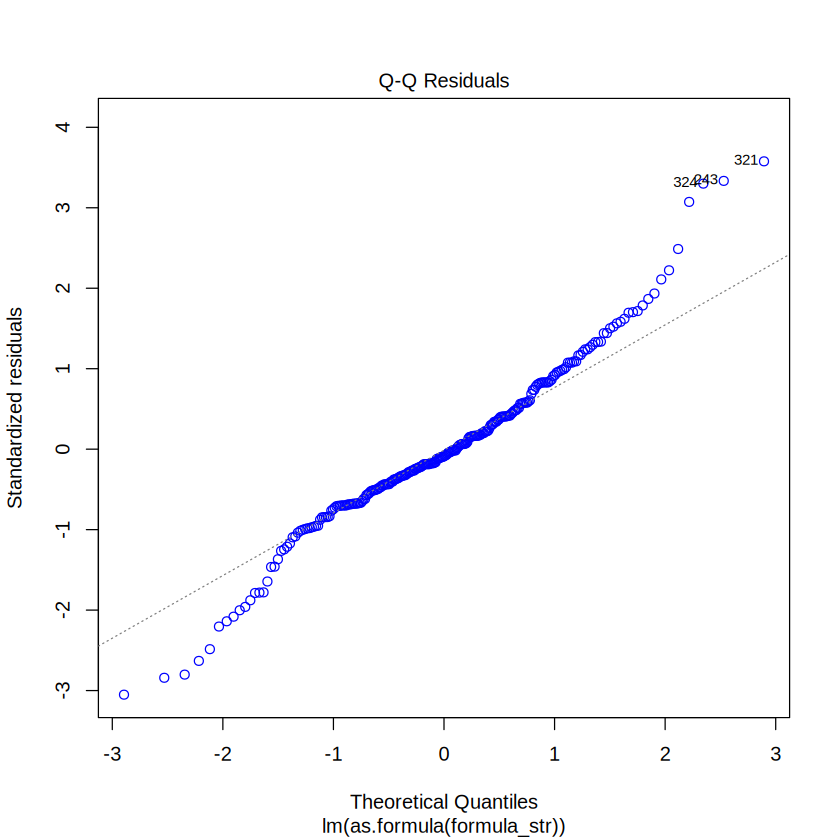

In [58]:
plot(best_model_lm, which=2, col=c("blue")) # QQ Plot

Cẩn thận hơn, chúng ta thử dùng Shapiro–Wilk test để kiểm tra có đúng thật là các giá trị thặng dư có phân phối chuẩn hay không?
- H0: Biến thặng dư của mô hình phân phối chuẩn trong một số quần thể.
- H1: Biến thặng dư của mô hình không phân phối chuẩn trong một số quần thể.

In [59]:
shapiro.test(residuals(best_model_lm))


	Shapiro-Wilk normality test

data:  residuals(best_model_lm)
W = 0.97205, p-value = 5.011e-05


Kết quả cho thấy p-value bé hơn mức ý nghĩa alpha 0.05 nên ta chưa có thể bác bỏ giả thhuyết H0, biến thặng dư của chúng ta chuẩn trong một số quần thể. 

#### Scale-Location

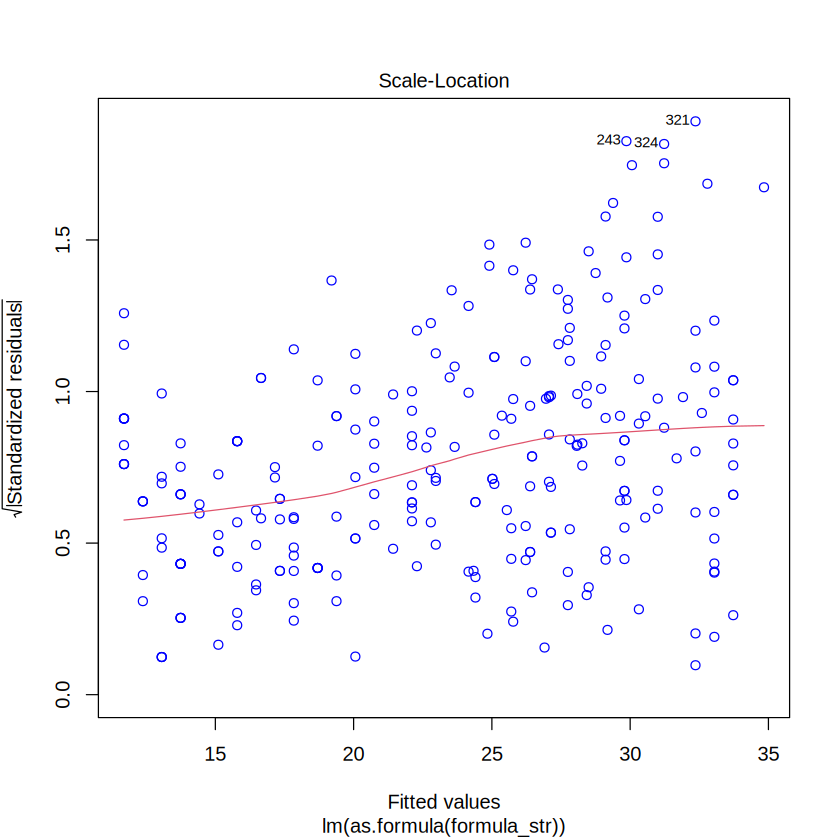

In [60]:
plot(best_model_lm, which=3, col=c("blue")) # Scale-Location

Ta phát hiện:
- Đường màu đỏ gần như nằm ngang trên biểu đồ. Nếu đúng như vậy thì giả định về tính đồng nhất được thỏa mãn đối với mô hình hồi quy đã cho. Nghĩa là, độ phân tán của giá trị thặng dư gần như bằng nhau ở tất cả các giá trị phù hợp.
- Các giá trị thặng  dư phải được phân tán ngẫu nhiên xung quanh đường màu đỏ với độ biến thiên gần như bằng nhau ở tất cả các giá trị phù hợp.

Cẩn thận hơn, chúng ta sử dụng Breusch-Pagan test để kiểm tra có thật là như vậy không?
- H0: Các giá trị thặng dư là homoscedastic
- H1: Các giá trị thặng dư là heteroscedastic

In [61]:
# Breusch-Pagan Test
bptest(best_model_lm)


	studentized Breusch-Pagan test

data:  best_model_lm
BP = 33.311, df = 4, p-value = 1.032e-06


Như vậy, ta thấy p-value bé hơn múc ý nghĩa 0.05 rất nhiều, ta chưa đủ điều kiện bác bỏ H0. Vậy các giá trị thặng dư là homoscedastic

#### Residuals vs Leverage

Biểu đồ này có thể được sử dụng để tìm các trường hợp có ảnh hưởng trong tập dữ liệu. Một trường hợp có ảnh hưởng là một trường hợp mà nếu bị loại bỏ sẽ ảnh hưởng đến mô hình nên việc đưa vào hoặc loại trừ nó cần được xem xét.

Một trường hợp có ảnh hưởng có thể là một trường hợp ngoại lệ hoặc không và mục đích của biểu đồ này là xác định các trường hợp có ảnh hưởng lớn đến mô hình. Các ngoại lệ sẽ có xu hướng có giá trị cực cao hoặc cực thấp và do đó ảnh hưởng đến mô hình.

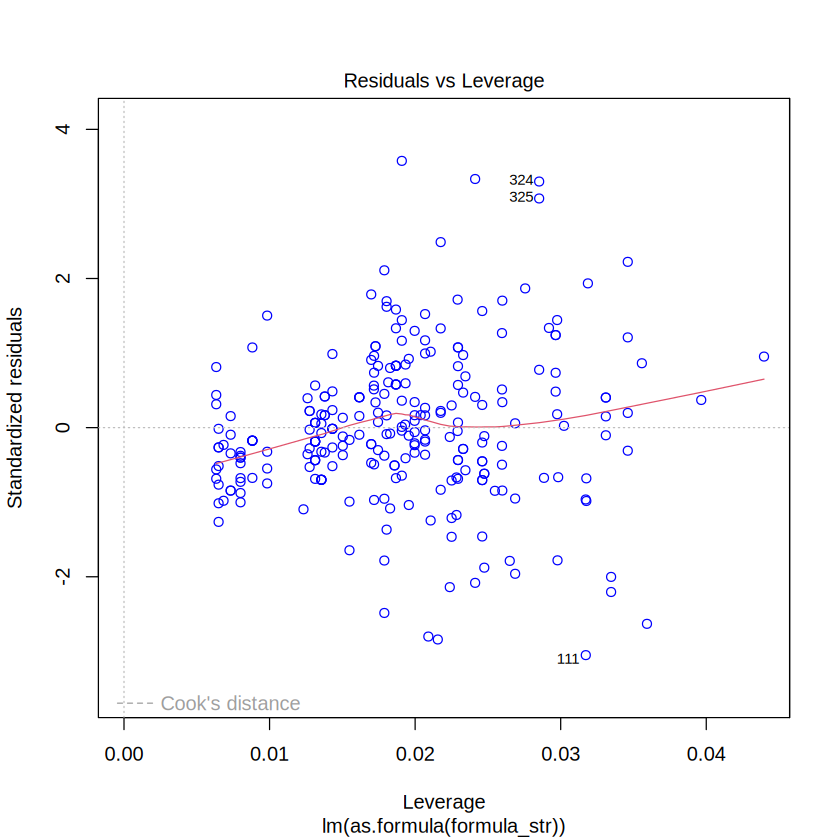

In [62]:
plot(best_model_lm, which=5, col=c("blue")) # Residuals vs Leverage

Ta nhận thấy có một số giá trị ngoại lai ở cách xa đường thằng giữa. Ta có thể xem rõ hơn thông qua histogram của Cook's Distance

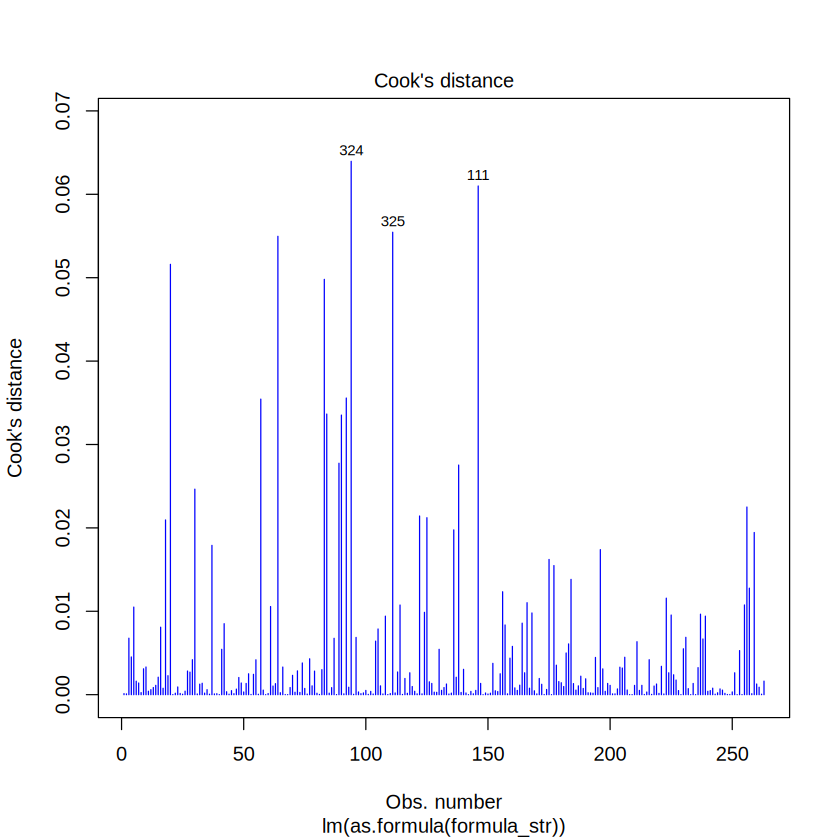

In [63]:
plot(best_model_lm, which=4, col=c("blue"))

### Dự đoán và đánh giá kết quả

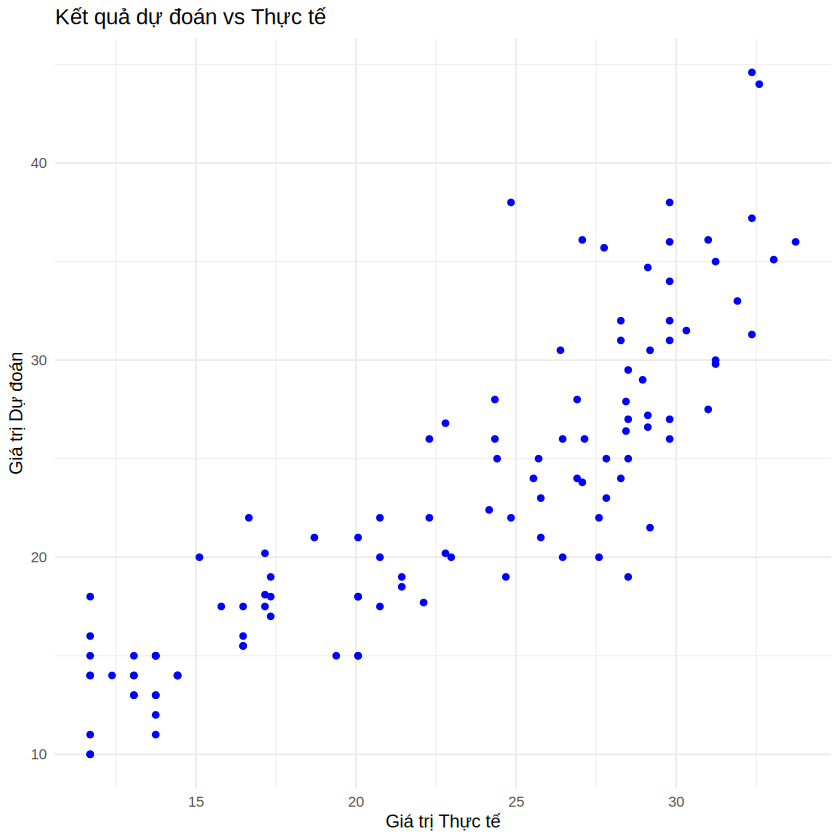

In [64]:
# predict
results <- predict(best_model_lm, test)
df <- data.frame(
    du_doan <- results,
    label <- test$mpg
)

library(ggplot2)
ggplot(df , aes(x = du_doan, y = label)) +
  geom_point(color = 'blue') +
  labs(
    title = "Kết quả dự đoán vs Thực tế",
    x = "Giá trị Thực tế",
    y = "Giá trị Dự đoán"
  ) +
  theme_minimal()

Tính toán RMSE

In [65]:
rmse(results, test$mpg)

[1] 3.916123

## Đánh giá xem mô hình thu được từ step và leaps, mô hình nào tốt hơn?

Nếu từ hai phương pháp, thu được hai phương trình hồi quy khác nhau, ta sẽ kiểm định. Nếu phương trình hồi quy giống nhau, mà chỉ khác hệ số, ta có thể dựa vào RMSE.

In [66]:
print(anova(model_best, best_model_lm))

Analysis of Variance Table

Model 1: mpg ~ cylinders + model_year + origin
Model 2: mpg ~ cylinders + model_year + origin
  Res.Df    RSS Df Sum of Sq F Pr(>F)
1    258 4166.4                      
2    258 4166.4  0         0         


## Kết luận

Như vậy, sau khi mô hình hóa chúng ta chọn được mô hình `mpg = -26.2835688 -2.5300874 * cylinders + 0.8237622 * model_year + 1.8539192 * origin2 + 3.9887288 * origin3`

Ta có thể thấy, số mét mỗi galon nhiên liệu bị ảnh hưởng bởi số lượng cylinders và năm sản suất. Khi mua xe, chúng ta cần xem xét số lượng cyliners, càng nhiều cyliners thì số mét mỗi galon nhiên liệu càng giảm, có nghĩa là tiêu hao nhiên liệu cao. Còn về tiêu chí năm ra đời của xe, xe càng mới, số mét mỗi galon nhiên liệu càng cao. Và chú ý chọn xe đến từ Europe và Asia nếu muốn xe tiết kiệm nhiên liệu.